In [1]:
# Google Colab setup
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir("drive/My Drive/adl4cv")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
# ONLY NECESSARY FOR LOCAL EXECUTION (WORKS WITHOUT THIS CELL IN GOOGLE COLAB)
# Setup that is necessary for jupyter notebook to find sibling-directories
# see: https://stackoverflow.com/questions/34478398/import-local-function-from-a-module-housed-in-another-directory-with-relative-im

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
# FROM i2dl for nice setup
# As usual, a bit of setup

import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# supress cluttering warnings in solutions
import warnings
warnings.filterwarnings('ignore')

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [4]:
# Imports for this notebook

from networks.baseline import BaselineModel
from training.solver import Solver
from training.single_image_dataloader import FaceForensicsImagesDataset, ToTensor
from torch.utils import data
from torch.utils.data.sampler import SubsetRandomSampler
import torch

In [6]:
data_location = ["/content/drive/My Drive/FaceForensics_Sequences/original_sequences/youtube/c40/sequences_299x299_skip_5_uniform",
                 "/content/drive/My Drive/FaceForensics_Sequences/manipulated_sequences/Deepfakes/c40/sequences_299x299_skip_5_uniform"]
dataset = FaceForensicsImagesDataset(data_location, transform=ToTensor())

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/My Drive/FaceForensics_Sequences/original_sequences/youtube/c40/sequences_299x299_skip_5_uniform'

In [8]:
# from: https://stackoverflow.com/questions/50544730/how-do-i-split-a-custom-dataset-into-training-and-test-datasets

batch_size = 16
validation_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler)

print("Train samples: {}".format(len(train_loader)))
print("Validation samples: {}".format(len(validation_loader)))

#for i, sample in enumerate(train_loader):
    
    #print("count of sequences in this batch: {}".format(sample["images"][0].shape[0]))
    
    #sequence = sample["images"][0][0, :, :, :, :]
    #labels_for_sequence = sample["labels"]
    #print(labels_for_sequence)
    
    #print(sequence.shape)
    #img = sequence[0].numpy()
    #img = np.moveaxis(img, 0, -1)  
    #plt.imshow(img)
    #plt.show()
    
    
    #print(sample["images"][0].shape)
    #print(sample["labels"][0].shape)

Train samples: 1504
Validation samples: 376


In [9]:
# Load baseline model
model = BaselineModel(model_choice='xception', num_out_classes=2, dropout=0.0)
model.train_only_last_layer()

print(model)
print("----------")
print("Only the following layers require gradient backpropagation (param.requires_grad)")
for name, param in model.model.named_parameters():
    if param.requires_grad:
        print("param: {} requires_grad: {}".format(name, param.requires_grad))

BaselineModel(
  (model): Xception(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (block1): Block(
      (skip): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (skipbn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (rep): Sequential(
        (0): SeparableConv2d(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
          (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        )
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inp

In [10]:
#configure solver and start training
solver = Solver(optim=torch.optim.Adam,
                optim_args={ "lr": 1e-4,
                             "betas": (0.9, 0.999),
                             "eps": 1e-8,
                             "weight_decay": 0.0}, # is the l2 regularization parameter, see: https://pytorch.org/docs/stable/optim.html
                loss_func=torch.nn.CrossEntropyLoss())

# Baseline must be trained to get the last classification layer to work correctly, because Xception-net is pretrained on
# ImageNet with 1000 class outputs and we only need 2.

solver.train(model, train_loader, validation_loader, num_epochs=1, log_nth=1)

START TRAIN on device: cpu
[Iteration 1/1504] TRAIN loss: 0.6814782023429871
[Iteration 2/1504] TRAIN loss: 0.7166607975959778
[Iteration 3/1504] TRAIN loss: 0.6982923150062561
[Iteration 4/1504] TRAIN loss: 0.7423661351203918
[Iteration 5/1504] TRAIN loss: 0.6828125715255737
[Iteration 6/1504] TRAIN loss: 0.7387696504592896
[Iteration 7/1504] TRAIN loss: 0.6866795420646667
[Iteration 8/1504] TRAIN loss: 0.6781045198440552
[Iteration 9/1504] TRAIN loss: 0.690377950668335
[Iteration 10/1504] TRAIN loss: 0.7055583000183105
[Iteration 11/1504] TRAIN loss: 0.6809815168380737
[Iteration 12/1504] TRAIN loss: 0.7284493446350098
[Iteration 13/1504] TRAIN loss: 0.6898170709609985
[Iteration 14/1504] TRAIN loss: 0.6566895842552185
[Iteration 15/1504] TRAIN loss: 0.7003687024116516
[Iteration 16/1504] TRAIN loss: 0.6790341138839722
[Iteration 17/1504] TRAIN loss: 0.6818832755088806
[Iteration 18/1504] TRAIN loss: 0.7254045009613037
[Iteration 19/1504] TRAIN loss: 0.6822009086608887
[Iteration 20/

[Iteration 161/1504] TRAIN loss: 0.6522026062011719
[Iteration 162/1504] TRAIN loss: 0.6486548185348511
[Iteration 163/1504] TRAIN loss: 0.6710810661315918
[Iteration 164/1504] TRAIN loss: 0.6672013401985168
[Iteration 165/1504] TRAIN loss: 0.70441073179245
[Iteration 166/1504] TRAIN loss: 0.6868324875831604
[Iteration 167/1504] TRAIN loss: 0.5918274521827698
[Iteration 168/1504] TRAIN loss: 0.6398880481719971
[Iteration 169/1504] TRAIN loss: 0.6515982151031494
[Iteration 170/1504] TRAIN loss: 0.6713086366653442
[Iteration 171/1504] TRAIN loss: 0.632537305355072
[Iteration 172/1504] TRAIN loss: 0.6466495990753174
[Iteration 173/1504] TRAIN loss: 0.6693681478500366
[Iteration 174/1504] TRAIN loss: 0.6722714900970459
[Iteration 175/1504] TRAIN loss: 0.6023446321487427
[Iteration 176/1504] TRAIN loss: 0.6709046363830566
[Iteration 177/1504] TRAIN loss: 0.5744804739952087
[Iteration 178/1504] TRAIN loss: 0.66764235496521
[Iteration 179/1504] TRAIN loss: 0.6809529662132263
[Iteration 180/15

[Iteration 320/1504] TRAIN loss: 0.6852946877479553
[Iteration 321/1504] TRAIN loss: 0.617434561252594
[Iteration 322/1504] TRAIN loss: 0.6155282258987427
[Iteration 323/1504] TRAIN loss: 0.6785503029823303
[Iteration 324/1504] TRAIN loss: 0.6442437171936035
[Iteration 325/1504] TRAIN loss: 0.6827360987663269
[Iteration 326/1504] TRAIN loss: 0.626459538936615
[Iteration 327/1504] TRAIN loss: 0.7026287317276001
[Iteration 328/1504] TRAIN loss: 0.6276369094848633
[Iteration 329/1504] TRAIN loss: 0.679965078830719
[Iteration 330/1504] TRAIN loss: 0.6384195685386658
[Iteration 331/1504] TRAIN loss: 0.6491782665252686
[Iteration 332/1504] TRAIN loss: 0.6842575073242188
[Iteration 333/1504] TRAIN loss: 0.663256049156189
[Iteration 334/1504] TRAIN loss: 0.5553625822067261
[Iteration 335/1504] TRAIN loss: 0.6123330593109131
[Iteration 336/1504] TRAIN loss: 0.5433787703514099
[Iteration 337/1504] TRAIN loss: 0.5985004305839539
[Iteration 338/1504] TRAIN loss: 0.5672300457954407
[Iteration 339/1

[Iteration 478/1504] TRAIN loss: 0.6258050203323364
[Iteration 479/1504] TRAIN loss: 0.5734462738037109
[Iteration 480/1504] TRAIN loss: 0.5962503552436829
[Iteration 481/1504] TRAIN loss: 0.6886484622955322
[Iteration 482/1504] TRAIN loss: 0.5993024706840515
[Iteration 483/1504] TRAIN loss: 0.5691453814506531
[Iteration 484/1504] TRAIN loss: 0.6013056635856628
[Iteration 485/1504] TRAIN loss: 0.5731296539306641
[Iteration 486/1504] TRAIN loss: 0.654719352722168
[Iteration 487/1504] TRAIN loss: 0.6026313304901123
[Iteration 488/1504] TRAIN loss: 0.6170767545700073
[Iteration 489/1504] TRAIN loss: 0.5484233498573303
[Iteration 490/1504] TRAIN loss: 0.5631142258644104
[Iteration 491/1504] TRAIN loss: 0.6239286661148071
[Iteration 492/1504] TRAIN loss: 0.6150643229484558
[Iteration 493/1504] TRAIN loss: 0.6523968577384949
[Iteration 494/1504] TRAIN loss: 0.6278154850006104
[Iteration 495/1504] TRAIN loss: 0.7099213600158691
[Iteration 496/1504] TRAIN loss: 0.6053116321563721
[Iteration 49

[Iteration 637/1504] TRAIN loss: 0.7412022352218628
[Iteration 638/1504] TRAIN loss: 0.5310635566711426
[Iteration 639/1504] TRAIN loss: 0.4989849925041199
[Iteration 640/1504] TRAIN loss: 0.6364789009094238
[Iteration 641/1504] TRAIN loss: 0.5879007577896118
[Iteration 642/1504] TRAIN loss: 0.6352540254592896
[Iteration 643/1504] TRAIN loss: 0.6569448113441467
[Iteration 644/1504] TRAIN loss: 0.6654366850852966
[Iteration 645/1504] TRAIN loss: 0.5669616460800171
[Iteration 646/1504] TRAIN loss: 0.6365023851394653
[Iteration 647/1504] TRAIN loss: 0.5439389944076538
[Iteration 648/1504] TRAIN loss: 0.6271461248397827
[Iteration 649/1504] TRAIN loss: 0.6223587393760681
[Iteration 650/1504] TRAIN loss: 0.5317620635032654
[Iteration 651/1504] TRAIN loss: 0.6006725430488586
[Iteration 652/1504] TRAIN loss: 0.6415675282478333
[Iteration 653/1504] TRAIN loss: 0.5672587156295776
[Iteration 654/1504] TRAIN loss: 0.5873252749443054
[Iteration 655/1504] TRAIN loss: 0.6102126240730286
[Iteration 6

[Iteration 795/1504] TRAIN loss: 0.5810368061065674
[Iteration 796/1504] TRAIN loss: 0.5801509022712708
[Iteration 797/1504] TRAIN loss: 0.6906397938728333
[Iteration 798/1504] TRAIN loss: 0.5192089676856995
[Iteration 799/1504] TRAIN loss: 0.4979420304298401
[Iteration 800/1504] TRAIN loss: 0.6093480587005615
[Iteration 801/1504] TRAIN loss: 0.703922688961029
[Iteration 802/1504] TRAIN loss: 0.6896288394927979
[Iteration 803/1504] TRAIN loss: 0.6835919618606567
[Iteration 804/1504] TRAIN loss: 0.6429253816604614
[Iteration 805/1504] TRAIN loss: 0.6082559823989868
[Iteration 806/1504] TRAIN loss: 0.645465075969696
[Iteration 807/1504] TRAIN loss: 0.5674504041671753
[Iteration 808/1504] TRAIN loss: 0.56556236743927
[Iteration 809/1504] TRAIN loss: 0.6712440252304077
[Iteration 810/1504] TRAIN loss: 0.5539376735687256
[Iteration 811/1504] TRAIN loss: 0.7178733944892883
[Iteration 812/1504] TRAIN loss: 0.5591285824775696
[Iteration 813/1504] TRAIN loss: 0.5716336965560913
[Iteration 814/1

[Iteration 953/1504] TRAIN loss: 0.645926296710968
[Iteration 954/1504] TRAIN loss: 0.6731208562850952
[Iteration 955/1504] TRAIN loss: 0.6219374537467957
[Iteration 956/1504] TRAIN loss: 0.6264490485191345
[Iteration 957/1504] TRAIN loss: 0.5994287729263306
[Iteration 958/1504] TRAIN loss: 0.5201430916786194
[Iteration 959/1504] TRAIN loss: 0.546570897102356
[Iteration 960/1504] TRAIN loss: 0.733322024345398
[Iteration 961/1504] TRAIN loss: 0.5383225083351135
[Iteration 962/1504] TRAIN loss: 0.5794466733932495
[Iteration 963/1504] TRAIN loss: 0.664746880531311
[Iteration 964/1504] TRAIN loss: 0.6247504353523254
[Iteration 965/1504] TRAIN loss: 0.5740045309066772
[Iteration 966/1504] TRAIN loss: 0.5888825058937073
[Iteration 967/1504] TRAIN loss: 0.6164997816085815
[Iteration 968/1504] TRAIN loss: 0.5744773149490356
[Iteration 969/1504] TRAIN loss: 0.5773366093635559
[Iteration 970/1504] TRAIN loss: 0.5227051973342896
[Iteration 971/1504] TRAIN loss: 0.5644940733909607
[Iteration 972/1

[Iteration 1109/1504] TRAIN loss: 0.5975990891456604
[Iteration 1110/1504] TRAIN loss: 0.4658348262310028
[Iteration 1111/1504] TRAIN loss: 0.6661173701286316
[Iteration 1112/1504] TRAIN loss: 0.4820248782634735
[Iteration 1113/1504] TRAIN loss: 0.5926228761672974
[Iteration 1114/1504] TRAIN loss: 0.5909562110900879
[Iteration 1115/1504] TRAIN loss: 0.5811033248901367
[Iteration 1116/1504] TRAIN loss: 0.5608927011489868
[Iteration 1117/1504] TRAIN loss: 0.5494734644889832
[Iteration 1118/1504] TRAIN loss: 0.5551831722259521
[Iteration 1119/1504] TRAIN loss: 0.6399637460708618
[Iteration 1120/1504] TRAIN loss: 0.6387149691581726
[Iteration 1121/1504] TRAIN loss: 0.6522838473320007
[Iteration 1122/1504] TRAIN loss: 0.619605541229248
[Iteration 1123/1504] TRAIN loss: 0.5545795559883118
[Iteration 1124/1504] TRAIN loss: 0.5611493587493896
[Iteration 1125/1504] TRAIN loss: 0.4936617314815521
[Iteration 1126/1504] TRAIN loss: 0.5610958933830261
[Iteration 1127/1504] TRAIN loss: 0.68515616655

[Iteration 1264/1504] TRAIN loss: 0.4690023958683014
[Iteration 1265/1504] TRAIN loss: 0.4849196970462799
[Iteration 1266/1504] TRAIN loss: 0.554912269115448
[Iteration 1267/1504] TRAIN loss: 0.6397880911827087
[Iteration 1268/1504] TRAIN loss: 0.6053626537322998
[Iteration 1269/1504] TRAIN loss: 0.5664937496185303
[Iteration 1270/1504] TRAIN loss: 0.577040433883667
[Iteration 1271/1504] TRAIN loss: 0.5693091750144958
[Iteration 1272/1504] TRAIN loss: 0.5866124629974365
[Iteration 1273/1504] TRAIN loss: 0.5767998099327087
[Iteration 1274/1504] TRAIN loss: 0.6743414998054504
[Iteration 1275/1504] TRAIN loss: 0.6742444634437561
[Iteration 1276/1504] TRAIN loss: 0.5686445832252502
[Iteration 1277/1504] TRAIN loss: 0.5919340252876282
[Iteration 1278/1504] TRAIN loss: 0.540733277797699
[Iteration 1279/1504] TRAIN loss: 0.5451875925064087
[Iteration 1280/1504] TRAIN loss: 0.5486600399017334
[Iteration 1281/1504] TRAIN loss: 0.6477459669113159
[Iteration 1282/1504] TRAIN loss: 0.5295966267585

[Iteration 1419/1504] TRAIN loss: 0.6521127223968506
[Iteration 1420/1504] TRAIN loss: 0.6687995195388794
[Iteration 1421/1504] TRAIN loss: 0.5807871222496033
[Iteration 1422/1504] TRAIN loss: 0.5301151275634766
[Iteration 1423/1504] TRAIN loss: 0.5764137506484985
[Iteration 1424/1504] TRAIN loss: 0.5503666996955872
[Iteration 1425/1504] TRAIN loss: 0.5698373317718506
[Iteration 1426/1504] TRAIN loss: 0.65287846326828
[Iteration 1427/1504] TRAIN loss: 0.5529679656028748
[Iteration 1428/1504] TRAIN loss: 0.6077454686164856
[Iteration 1429/1504] TRAIN loss: 0.521052896976471
[Iteration 1430/1504] TRAIN loss: 0.4884454905986786
[Iteration 1431/1504] TRAIN loss: 0.5740342140197754
[Iteration 1432/1504] TRAIN loss: 0.523557722568512
[Iteration 1433/1504] TRAIN loss: 0.5802007913589478
[Iteration 1434/1504] TRAIN loss: 0.669857919216156
[Iteration 1435/1504] TRAIN loss: 0.48420804738998413
[Iteration 1436/1504] TRAIN loss: 0.4957503378391266
[Iteration 1437/1504] TRAIN loss: 0.43742540478706

KeyboardInterrupt: 

In [0]:
'''
print(dataset.__len__())
print(dataset.shape)
train_dataset = dataset[:20]
val_dataset = dataset[20:]

print(train_dataset.__len__())
print(val_dataset.__len__())


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=4)

#for i, sample in enumerate(train_loader):
#    print(sample["images"][0].shape)
#    print(sample["labels"][0].shape)

val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=True, num_workers=4)

#solver.train(model, train_loader, val_loader, num_epochs=2, log_nth=1000)
'''

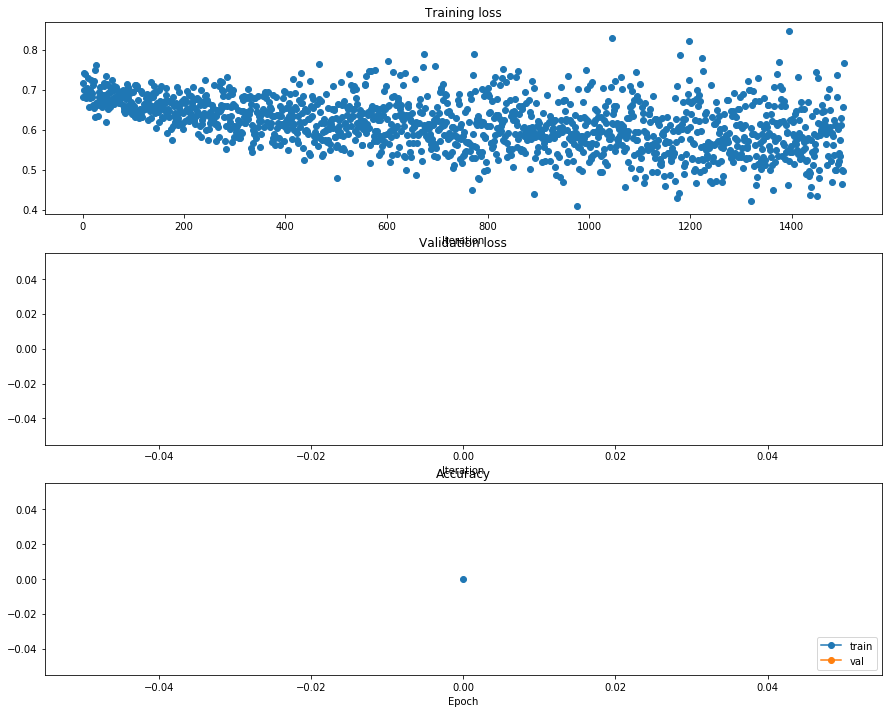

In [11]:
# Run this cell to visualize training loss and train / val accuracy

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.plot(solver.train_loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Validation loss')
plt.plot(solver.val_loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(3, 1, 3)
plt.title('Accuracy')
plt.plot(solver.train_acc_history, '-o', label='train')
plt.plot(solver.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

Now try to use a five-layer network with 100 units on each layer to overfit 50 training examples. Again you will have to adjust the learning rate and weight initialization, but you should be able to achieve 100% training accuracy within 20 epochs.

# Save the model

### 1) Save the network with its weights
Uses torch.save
https://pytorch.org/docs/stable/notes/serialization.html#recommend-saving-models

Load again with
<code>
the_model = TheModelClass(&ast;args, &ast;&ast;kwargs)
the_model.load_state_dict(torch.load(PATH))
</code>

In [115]:
def save_model(modelname, model):
    filepath = "../saved_results/models/" + modelname + ".pt"
    torch.save(model.state_dict, filepath)

### 2) Save the training configuration
Saves the most important model and training parameters and training results.

The following things are saved in this step:
* Training set size & Validation set size   ✓
* Arguments passed to the solver such as
    * Learning rate   ✓
    * Learning rate optimization algorithm (e.g. Adam) and their variables   ✓
    * Regularization parameter (e.g. weight decay)   ✓
    * Number of epochs   (✓)
* Loss function   ✓
* Most important network specifications such as
    * Input dimension   ✓
    * Model layout   ✓
    * ...
* Training results
    * Final loss   ✓
    * Final training accuracy   ✓
    * Final validation accuracy   ✓

In [116]:
def save_training_config(modelname, model, solver, train_indices=[], val_indices=[], num_epochs=-1):
    # Capital keys appear first in the file -> Have the model appear at the end

    filepath = "../saved_results/configs/" + modelname + ".json"
    num_epochs = 66

    training_config = {}
    training_config["Train_set_size"] = len(train_indices)
    training_config["Val_set_size"] = len(val_indices)

    training_config["Solver_optim"] = str(solver.optim)
    training_config["Optim_args"] = solver.optim_args
    training_config["Loss_func"] = str(solver.loss_func)

    training_config["Input_dim"] = first_input.shape
    training_config["model_layout"] = str(model.extra_repr)

    training_config["Num_epochs"] = num_epochs
    training_config["Final_loss"] = str(solver.train_loss_history[-1] if len(solver.train_loss_history) > 0 else -1)
    training_config["Final_train_acc"] = str(solver.train_acc_history[-1] if len(solver.train_acc_history) > 0 else -1)
    training_config["Final_val_acc"] = str(solver.val_acc_history[-1] if len(solver.val_acc_history) > 0 else -1)

    import json

    with open(filepath, 'w') as outfile:
        json.dump(training_config, outfile, sort_keys=True)

### 3) Save the entire training history

Saves the entire history of training and validation error and loss.

In [117]:
def save_training_history(modelname, solver):
    filepath = "../saved_results/histories/" + modelname + ".json"

    history = {}

    history["train_loss_history"] = solver.train_loss_history
    history["train_acc_history"] = solver.train_acc_history
    history["val_acc_history"] = solver.val_acc_history
    
    import json

    with open(filepath, 'w') as outfile:
        json.dump(training_config, outfile, sort_keys=True)


### 4) Save all

In [118]:
def save_all(modelname, model, solver, train_indices=[], val_indices=[], num_epochs=-1):
    save_model(modelname, model)
    save_training_config(modelname, model, solver, train_indices, val_indices, num_epochs=-1)
    save_training_history(modelname, solver)

In [119]:
save_all("test_model", model, solver, train_indices=train_indices)